In [14]:
import os
import gzip
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from xraydb import mu_elam
import gzip

# Spectral CT Decomposition

Karl Schmidt

## Table of Contents

* [Introduction](#introduction)
* [Dataset Description](#dataset-description)
* [Exploratory Data Analysis](#exploratory-data-analysis)
* [Model Building and Training](#model-building-and-training)
* [Results & Analysis](#results-and-analysis)
* [Conclusion](#conclusion)

# Introduction

 

# Dataset Description

[2022 AAPM Spectral CT Dataset](https://zenodo.org/records/14262737)

# Exploratory Data Analysis

In [6]:
# --- 1. File Listing ---
data_dir = './data'
files = os.listdir(data_dir)
print("Data files:")
for f in files:
    print(f)


Data files:
lowkVpTransmission.npy.gz
highkVpTransmission.npy.gz
lowkVpImages.npy.gz
starting_kit.tgz
14262737.zip
Phantom_Calcification.npy.gz
Phantom_Fibroglandular.npy.gz
highkVpImages.npy.gz
Phantom_Adipose.npy.gz


In [7]:
# --- 2. Load compressed numpy arrays ---
def load_npy_gz(path):
    with gzip.open(path, 'rb') as f:
        return np.load(f)

In [25]:
# --- 3. Identify and load key arrays ---
# Image volumes
high_img_path  = os.path.join(data_dir, 'highkVpImages.npy.gz')
low_img_path   = os.path.join(data_dir, 'lowkVpImages.npy.gz')
# Transmission volumes
high_tx_path   = os.path.join(data_dir, 'highkVpTransmission.npy.gz')
low_tx_path    = os.path.join(data_dir, 'lowkVpTransmission.npy.gz')
# Mask volumes (handle possible typos in filenames)
mask_files = os.listdir(data_dir)
adipose_path = next(os.path.join(data_dir, f) for f in mask_files if 'Phantom_Adipose' in f)
fibro_path   = next(os.path.join(data_dir, f) for f in mask_files if 'Fibroglandular' in f)
calc_path    = next(os.path.join(data_dir, f) for f in mask_files if 'Calcif' in f)

# Load
high_imgs = load_npy_gz(high_img_path)
low_imgs  = load_npy_gz(low_img_path)
high_tx   = load_npy_gz(high_tx_path)
low_tx    = load_npy_gz(low_tx_path)
adipose   = load_npy_gz(adipose_path)
fibro     = load_npy_gz(fibro_path)
calc      = load_npy_gz(calc_path)
print("All arrays loaded.\n")

All arrays loaded.



In [26]:
# --- 4. Print shapes of each array ---
shapes = {
    'high_imgs': high_imgs.shape,
    'low_imgs':  low_imgs.shape,
    'high_tx':   high_tx.shape,
    'low_tx':    low_tx.shape,
    'adipose':   adipose.shape,
    'fibro':     fibro.shape,
    'calc':      calc.shape
}
print("Array shapes:")
print(pd.Series(shapes, name='shape'))

Array shapes:
high_imgs     (1000, 512, 512)
low_imgs      (1000, 512, 512)
high_tx      (1000, 256, 1024)
low_tx       (1000, 256, 1024)
adipose       (1000, 512, 512)
fibro         (1000, 512, 512)
calc          (1000, 512, 512)
Name: shape, dtype: object


In [27]:
# --- 5. Summary statistics for image/transmission volumes ---
def summarize(arr, name):
    flat = arr.flatten()
    stats = {
        'min': np.min(flat),
        '1st_pct': np.percentile(flat, 1),
        'median': np.median(flat),
        'mean': np.mean(flat),
        '99th_pct': np.percentile(flat, 99),
        'max': np.max(flat)
    }
    print(f"\n{name} stats:")
    print(pd.Series(stats))

for array, name in [(high_imgs, 'high_imgs'), (low_imgs, 'low_imgs'),
                    (high_tx, 'high_tx'), (low_tx, 'low_tx')]:
    summarize(array, name)


high_imgs stats:
min        -0.043410
1st_pct    -0.009551
median      0.205673
mean        0.134265
99th_pct    0.242118
max         0.965312
dtype: float32

low_imgs stats:
min        -0.067658
1st_pct    -0.016681
median      0.244768
mean        0.163604
99th_pct    0.307665
max         1.797690
dtype: float32

high_tx stats:
min         0.022180
1st_pct     0.028576
median      0.059616
mean        0.199160
99th_pct    1.000000
max         1.000000
dtype: float32

low_tx stats:
min         0.007638
1st_pct     0.012597
median      0.032953
mean        0.171179
99th_pct    1.000000
max         1.000000
dtype: float32


In [23]:
# --- 5. Summary statistics for image/transmission volumes ---
def summarize(arr, name):
    flat = arr.flatten()
    stats = {
        'min': np.min(flat),
        '1st_pct': np.percentile(flat, 1),
        'median': np.median(flat),
        'mean': np.mean(flat),
        '99th_pct': np.percentile(flat, 99),
        'max': np.max(flat)
    }
    print(f"\n{name} stats:")
    print(pd.Series(stats))

for array, name in [(high_imgs, 'high_imgs'), (low_imgs, 'low_imgs'),
                    (high_tx, 'high_tx'), (low_tx, 'low_tx')]:
    summarize(array, name)



high_imgs stats:
min        -0.043410
1st_pct    -0.009551
median      0.205673
mean        0.134265
99th_pct    0.242118
max         0.965312
dtype: float32

low_imgs stats:
min        -0.067658
1st_pct    -0.016681
median      0.244768
mean        0.163604
99th_pct    0.307665
max         1.797690
dtype: float32

high_tx stats:
min         0.022180
1st_pct     0.028576
median      0.059616
mean        0.199160
99th_pct    1.000000
max         1.000000
dtype: float32

low_tx stats:
min         0.007638
1st_pct     0.012597
median      0.032953
mean        0.171179
99th_pct    1.000000
max         1.000000
dtype: float32


In [28]:
# --- 6. Mask coverage (% of non-zero voxels) ---
total = high_imgs.size
print("\nMask coverage (% of total voxels):")
for m, name in [(adipose, 'adipose'), (fibro, 'fibro'), (calc, 'calc')]:
    pct = m.sum() / total * 100
    print(f" - {name}: {pct:.3f}%")


Mask coverage (% of total voxels):
 - adipose: 42.617%
 - fibro: 19.408%
 - calc: 0.032%


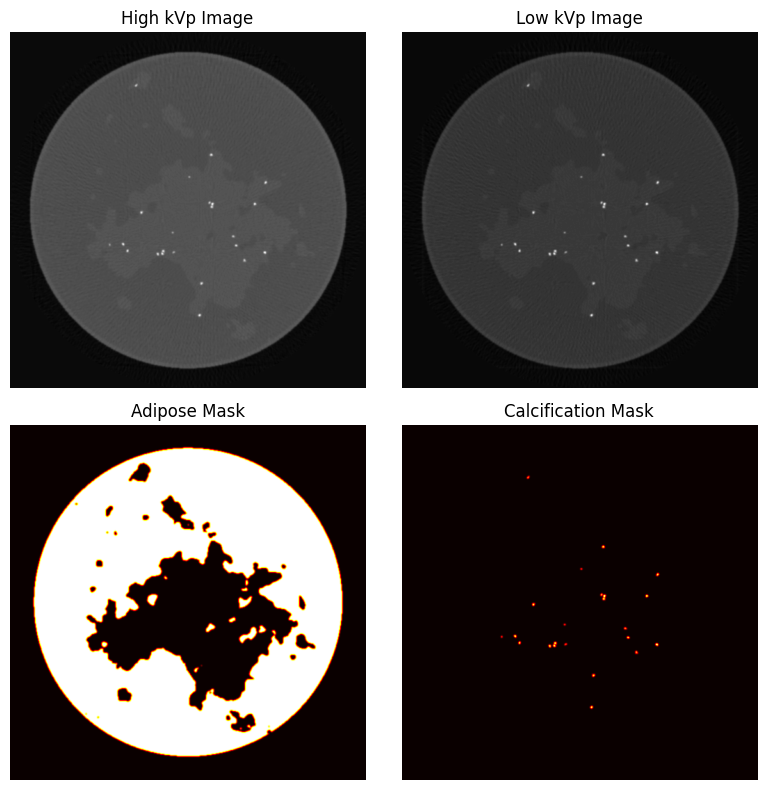

In [29]:
# --- 7. Visualize a random slice of images & masks ---
idx = np.random.randint(high_imgs.shape[0])
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0,0].imshow(high_imgs[idx], cmap='gray'); axs[0,0].set_title('High kVp Image')
axs[0,1].imshow(low_imgs[idx],  cmap='gray'); axs[0,1].set_title('Low kVp Image')
axs[1,0].imshow(adipose[idx], cmap='hot');   axs[1,0].set_title('Adipose Mask')
axs[1,1].imshow(calc[idx],    cmap='hot');   axs[1,1].set_title('Calcification Mask')
for ax in axs.flatten(): ax.axis('off')
plt.tight_layout(); plt.show()

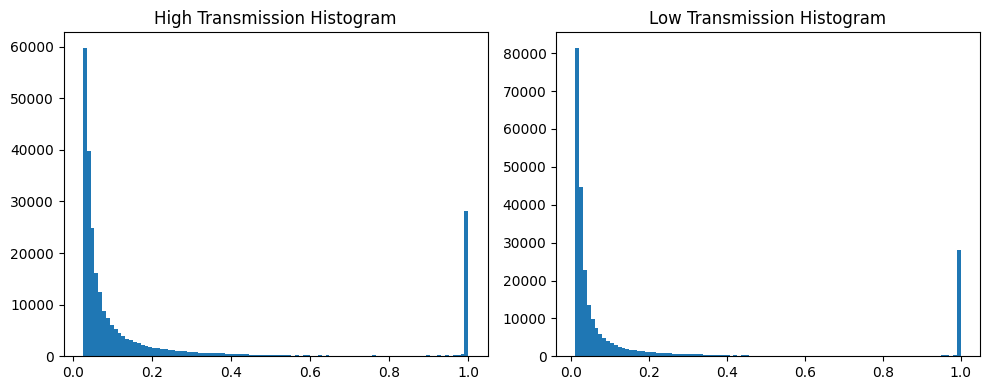

In [19]:
# --- 8. Histograms of transmission for same slice ---
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist(high_tx[idx].ravel(), bins=100); axs[0].set_title('High Transmission Histogram')
axs[1].hist(low_tx[idx].ravel(),  bins=100); axs[1].set_title('Low Transmission Histogram')
plt.tight_layout(); plt.show()

In [20]:
# --- 9. Explore starting kit contents and README ---
kit_path = os.path.join(data_dir, 'starting_kit.tgz')
print("\nStarting kit contents:")
with tarfile.open(kit_path, 'r:gz') as tar:
    for member in tar.getmembers():
        print(" -", member.name)
    try:
        readme = tar.extractfile('starting_kit/README')
        print("\nREADME preview:")
        for i, line in enumerate(readme.readlines()):
            print(line.decode('utf-8').rstrip())
            if i >= 9:
                print('...')
                break
    except KeyError:
        print("README not found in starting_kit.")


Starting kit contents:
 - ._starting_kit
 - starting_kit
 - starting_kit/._metrics.py
 - starting_kit/metrics.py
 - starting_kit/._TestPrediction_Fibroglandular.npy
 - starting_kit/TestPrediction_Fibroglandular.npy
 - starting_kit/._.DS_Store
 - starting_kit/.DS_Store
 - starting_kit/._highkVpImages.npy
 - starting_kit/highkVpImages.npy
 - starting_kit/._TestPrediction_Calcification.npy
 - starting_kit/TestPrediction_Calcification.npy
 - starting_kit/._README
 - starting_kit/README
 - starting_kit/._lowkVpImages.npy
 - starting_kit/lowkVpImages.npy
 - starting_kit/._TestPrediction_Adipose.npy
 - starting_kit/TestPrediction_Adipose.npy
 - starting_kit/._Phantom_Adipose.npy
 - starting_kit/Phantom_Adipose.npy
 - starting_kit/._model
 - starting_kit/model
 - starting_kit/._lowkVpTransmission.npy
 - starting_kit/lowkVpTransmission.npy
 - starting_kit/._Phantom_Fibroglandular.npy
 - starting_kit/Phantom_Fibroglandular.npy
 - starting_kit/._highkVpTransmission.npy
 - starting_kit/highkVpTra

Attenuation stats per material:
         mean_low   std_low  mean_high  std_high
adipose  0.257000  0.021287   0.212581  0.011647
fibro    0.253225  0.081398   0.205105  0.062642
calc     0.361922  0.185496   0.266459  0.088884


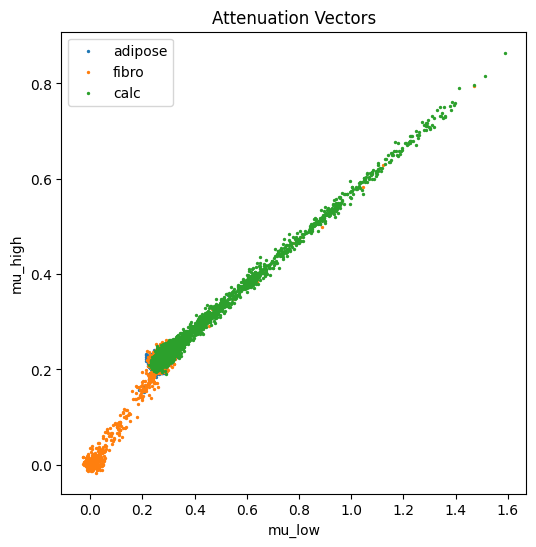

In [31]:
# --- 10. Use reconstructed images as attenuation maps ---
# high_imgs and low_imgs are already reconstructed attenuation images (e.g., in Hounsfield units or mu maps)
mu_low_img  = low_imgs
mu_high_img = high_imgs

# Summary per material using image-based attenuation
materials = [('adipose', adipose), ('fibro', fibro), ('calc', calc)]
attn_stats = {}
for name, mask in materials:
    # mask shape matches image shape: (N, H, W)
    vals_low  = mu_low_img[mask > 0]
    vals_high = mu_high_img[mask > 0]
    stats = {
        'mean_low':  np.mean(vals_low),
        'std_low':   np.std(vals_low),
        'mean_high': np.mean(vals_high),
        'std_high':  np.std(vals_high)
    }
    attn_stats[name] = stats
print("Attenuation stats per material:")
print(pd.DataFrame(attn_stats).T)

# Scatter plot of attenuation vectors by material
plt.figure(figsize=(6,6))
for name, mask in materials:
    # sample points for clarity
    pt_low  = mu_low_img[mask > 0].flatten()
    pt_high = mu_high_img[mask > 0].flatten()
    idxs = np.random.choice(len(pt_low), size=5000, replace=False)
    plt.scatter(pt_low[idxs], pt_high[idxs], s=2, label=name)
plt.xlabel('mu_low'); plt.ylabel('mu_high'); plt.title('Attenuation Vectors'); plt.legend()
plt.show()

# Model Architecture

Originally, I tried building a DCGAN to apply monet styling to the standard photos. However, it became apparent that DCGAN would not be a good option because it is meant for generating images from scratch and the purpose of this project is to perform image style transfer. Here, I've moved to a Cycle GAN which is more suiteable for image style transfer.

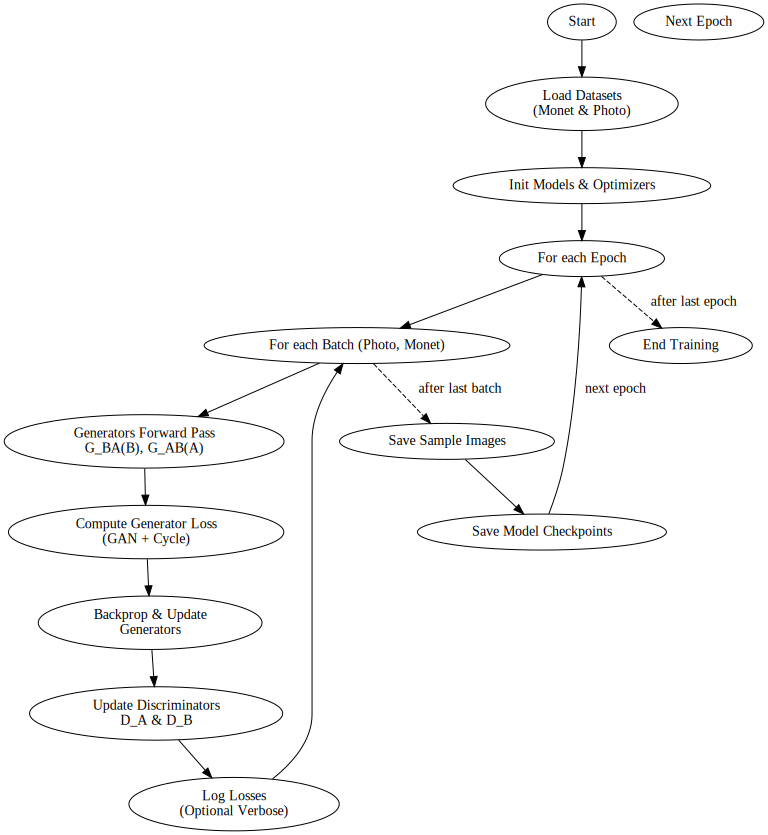

In [12]:
from graphviz import Digraph

# Build the flowchart
dot = Digraph(name="CycleGAN_Training_Flowchart", format="png")

# Nodes
dot.node("Start", "Start")
dot.node("LoadData", "Load Datasets\n(Monet & Photo)")
dot.node("Init", "Init Models & Optimizers")
dot.node("EpochLoop", "For each Epoch")
dot.node("BatchLoop", "For each Batch (Photo, Monet)")
dot.node("GenForward", "Generators Forward Pass\nG_BA(B), G_AB(A)")
dot.node("GenLoss", "Compute Generator Loss\n(GAN + Cycle)")
dot.node("GenBackward", "Backprop & Update\nGenerators")
dot.node("DiscUpdate", "Update Discriminators\nD_A & D_B")
dot.node("Log", "Log Losses\n(Optional Verbose)")
dot.node("SaveSamples", "Save Sample Images")
dot.node("SaveChkpt", "Save Model Checkpoints")
dot.node("NextEpoch", "Next Epoch")
dot.node("End", "End Training")

# Edges
dot.edges([("Start", "LoadData"),
           ("LoadData", "Init"),
           ("Init", "EpochLoop"),
           ("EpochLoop", "BatchLoop"),
           ("BatchLoop", "GenForward"),
           ("GenForward", "GenLoss"),
           ("GenLoss", "GenBackward"),
           ("GenBackward", "DiscUpdate"),
           ("DiscUpdate", "Log"),
           ("Log", "BatchLoop")])  # loop back for next batch

# After finishing batches
dot.edge("BatchLoop", "SaveSamples", label="after last batch", style="dashed")
dot.edge("SaveSamples", "SaveChkpt")
dot.edge("SaveChkpt", "EpochLoop", label="next epoch")

# After all epochs
dot.edge("EpochLoop", "End", label="after last epoch", style="dashed")

# Display the diagram
dot

In [ ]:
# 1. Load AAPM DL-Spectral CT Challenge data (assuming files are in working directory)
low_imgs  = np.load(gzip.open('lowkVpImages.npy.gz', 'rb'))   # shape (N, H, W)
high_imgs = np.load(gzip.open('highkVpImages.npy.gz', 'rb'))
labels    = np.zeros_like(low_imgs, dtype=np.int64)
mask_adipose = np.load(gzip.open('Phantom_Adipose.npy.gz', 'rb'))
mask_fibro   = np.load(gzip.open('Phantom_Fibroglandular.npy.gz', 'rb'))
mask_calc    = np.load(gzip.open('Phantom_Calcification.npy.gz', 'rb'))
labels[mask_adipose > 0] = 0
labels[mask_fibro   > 0] = 1
labels[mask_calc    > 0] = 2

# Placeholder for sinogram data (if available; shapes must match)
projs_low  = np.load('sinogram_low.npy')   # shape (N, num_angles, detector_pixels)
projs_high = np.load('sinogram_high.npy')

# 2. Compute mass attenuation coefficients (μ/ρ) for basis materials at two energies
E_low, E_high = 40000, 80000  # in eV
mu_basis_low  = torch.tensor([
    mu_elam('C',  E_low),    # adipose proxy
    mu_elam('O',  E_low),    # fibroglandular proxy
    mu_elam('Ca', E_low)     # calcification proxy
], dtype=torch.float32).cuda()
mu_basis_high = torch.tensor([
    mu_elam('C',  E_high),
    mu_elam('O',  E_high),
    mu_elam('Ca', E_high)
], dtype=torch.float32).cuda()

In [ ]:
# 3. Create a Dataset for image-level training
class SCTDataset(Dataset):
    def __init__(self, low, high, sinlow, sinhigh, lbls):
        self.low     = torch.from_numpy(low).float()
        self.high    = torch.from_numpy(high).float()
        self.sinlow  = torch.from_numpy(sinlow).float()
        self.sinhigh = torch.from_numpy(sinhigh).float()
        self.lbls    = torch.from_numpy(lbls).long()
    def __len__(self):
        return self.low.shape[0]
    def __getitem__(self, idx):
        return (self.low[idx], self.high[idx],
                self.sinlow[idx], self.sinhigh[idx],
                self.lbls[idx])

In [ ]:
dataset = SCTDataset(low_imgs, high_imgs, projs_low, projs_high, labels)
loader  = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
# 4. Define a pixel-wise MLP classifier
class PixelMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 3)
        )
    def forward(self, low_img, high_img):
        B, H, W = low_img.shape
        # Stack and flatten pixel vectors
        x = torch.stack([low_img, high_img], dim=-1).view(-1, 2)
        logits = self.mlp(x) \
                    .view(B, H, W, 3) \
                    .permute(0, 3, 1, 2)  # (B, 3, H, W)
        return logits

In [ ]:
model = PixelMLP().cuda()

# 5. Set up a differentiable forward projector
num_angles = projs_low.shape[1]
angles = torch.linspace(0, np.pi, num_angles, dtype=torch.float32).cuda()
radon = Radon(img_size=low_imgs.shape[1], angles=angles)

# 6. Training loop with combined classification, physics, and projection losses
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
alpha_phy   = 0.5  # weight for physics-based attenuation loss
alpha_proj  = 0.1  # weight for projection consistency loss

for epoch in range(10):
    total_loss = 0.0
    for low_img, high_img, sinlow, sinhigh, lbl in loader:
        # Move data to GPU
        low_img  = low_img.cuda()
        high_img = high_img.cuda()
        sinlow   = sinlow.cuda()
        sinhigh  = sinhigh.cuda()
        lbl      = lbl.cuda()

        # Forward: classification logits
        logits = model(low_img, high_img)  # (1,3,H,W)

        # 1) Classification loss
        ce_loss = F.cross_entropy(logits, lbl)

        # 2) Physics-informed loss: reconstruct attenuation maps
        probs = F.softmax(logits, dim=1)  # (B,3,H,W)
        mu_pred_low  = torch.sum(probs * mu_basis_low.view(1, 3, 1, 1), dim=1)
        mu_pred_high = torch.sum(probs * mu_basis_high.view(1, 3, 1, 1), dim=1)
        phy_loss = F.mse_loss(mu_pred_low, low_img) + F.mse_loss(mu_pred_high, high_img)

        # 3) Projection consistency loss
        proj_pred_low  = radon(mu_pred_low)
        proj_pred_high = radon(mu_pred_high)
        proj_loss = F.mse_loss(proj_pred_low, sinlow) + F.mse_loss(proj_pred_high, sinhigh)

        # 4) Total loss
        loss = ce_loss + alpha_phy * phy_loss + alpha_proj * proj_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d}, Loss: {total_loss/len(loader):.4f}")

In [ ]:
# --- 1. Load precomputed attenuation images ---
low_attn = np.load('low_attn.npy')      
high_attn = np.load('high_attn.npy')    
labels    = np.load('tissue_labels.npy')

# --- 2. Dataset yielding per-pixel attenuation vectors ---
class AttnVectorDataset(Dataset):
    def __init__(self, low, high, labels):
        vectors = np.stack([low, high], axis=-1)       # (N,H,W,2)
        self.vectors = torch.from_numpy(vectors).float().view(-1, 2)
        self.labels  = torch.from_numpy(labels).long().view(-1)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.vectors[idx], self.labels[idx]

dataset    = AttnVectorDataset(low_attn, high_attn, labels)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True, num_workers=2)

# --- 3. MLP with energy‐specific cosine features ---
class EnergyAwareMLP(nn.Module):
    def __init__(self, basis_vectors):
        super().__init__()
        # basis_vectors: list of [mu_low, mu_high] per class
        self.basis = torch.tensor(basis_vectors, dtype=torch.float32)  # (C,2)
        self.cos = nn.CosineSimilarity(dim=1)
        C = self.basis.size(0)
        # input dims: 2 raw + C full‐cos + C low‐cos + C high‐cos
        in_dim = 2 + 3 * C
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64), nn.ReLU(),
            nn.Linear(64, 64),     nn.ReLU(),
            nn.Linear(64, C)
        )

    def forward(self, x):
        # x: (B,2)
        B = x.size(0)
        C = self.basis.size(0)
        # full cosine similarities
        xb = x.unsqueeze(1).expand(-1, C, -1).contiguous().view(-1, 2)
        bb = self.basis.unsqueeze(0).expand(B, -1, -1).contiguous().view(-1, 2)
        cos_full = self.cos(xb, bb).view(B, C)
        # low‐energy cos: (x[:,0]·b[i,0])/(|x[:,0]|·|b[i,0]|)
        x_low = x[:, 0].unsqueeze(1)  # (B,1)
        b_low = self.basis[:, 0].unsqueeze(0)  # (1,C)
        cos_low = (x_low * b_low) / (x_low.abs() * b_low.abs() + 1e-8)  # (B,C)
        # high‐energy cos
        x_high = x[:, 1].unsqueeze(1)
        b_high = self.basis[:, 1].unsqueeze(0)
        cos_high = (x_high * b_high) / (x_high.abs() * b_high.abs() + 1e-8)
        # concatenate raw features + all similarity features
        x_aug = torch.cat([x, cos_full, cos_low, cos_high], dim=1)
        return self.net(x_aug)

# --- 4. Example usage ---
basis = [[0.22, 0.15], [0.30, 0.25], [0.45, 0.40]]
model = EnergyAwareMLP(basis).cuda()

# --- 5. Training loop ---
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()
for epoch in range(10):
    tot = 0
    for x, y in dataloader:
        x, y = x.cuda(), y.cuda()
        logits = model(x)
        loss = crit(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()
    print(f"Epoch {epoch+1}, Loss {tot/len(dataloader):.4f}")

# --- 6. Quick inference check ---
xs, ys = next(iter(dataloader))
with torch.no_grad(): preds = model(xs.cuda()).argmax(dim=1)
print("Acc:", (preds.cpu()==ys).float().mean())

# Results & Analysis

Hello

# Conclusion